In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics
!pip install timm
!pip install opencv-python
!pip install pillow
!pip install matplotlib seaborn scikit-learn

done
Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import time
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Your Google Drive paths
DRIVE_PATHS = {
    'earthquake': '/content/drive/MyDrive/IntelliHack/Earthquake',
    'fire': '/content/drive/MyDrive/IntelliHack/Fire',
    'flood': '/content/drive/MyDrive/IntelliHack/Flood',
    'normal': '/content/drive/MyDrive/IntelliHack/Normal'
}

for disaster, path in DRIVE_PATHS.items():
    print(f"   {disaster}: {path}")

Using device: cpu
   earthquake: /content/drive/MyDrive/IntelliHack/Earthquake
   fire: /content/drive/MyDrive/IntelliHack/Fire
   flood: /content/drive/MyDrive/IntelliHack/Flood
   normal: /content/drive/MyDrive/IntelliHack/Normal


In [ ]:
def verify_and_copy_data():
    """Verify Google Drive data and copy to local dataset folder"""

    # Create local dataset structure
    os.makedirs('dataset', exist_ok=True)

    total_images = 0
    dataset_info = {}

    print("CHECKING YOUR GOOGLE DRIVE DATA:")
    print("-" * 50)

    for disaster_type, drive_path in DRIVE_PATHS.items():
        local_path = f'dataset/{disaster_type}'
        os.makedirs(local_path, exist_ok=True)

        if os.path.exists(drive_path):
            # Get all image files from Google Drive
            image_files = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.JPG', '*.JPEG', '*.PNG']:
                image_files.extend(glob.glob(os.path.join(drive_path, ext)))

            count = len(image_files)
            total_images += count
            dataset_info[disaster_type] = count

            print(f"{disaster_type.capitalize():>10}: {count:>3} images")

            # Copy files to local dataset folder for faster training
            if count > 0:
                print(f"  Copying {disaster_type} images...")
                for i, img_file in enumerate(image_files):
                    try:
                        import shutil
                        filename = os.path.basename(img_file)
                        dst = os.path.join(local_path, filename)
                        shutil.copy2(img_file, dst)

                        if (i + 1) % 10 == 0 or (i + 1) == count:
                            print(f"    Copied {i + 1}/{count} files...")
                    except Exception as e:
                        print(f"    Error copying {filename}: {e}")

                print(f"    {disaster_type} files copied successfully!")

        else:
            print(f"{disaster_type.capitalize():>10}:  PATH NOT FOUND: {drive_path}")
            dataset_info[disaster_type] = 0

    print("-" * 50)
    print(f"{'TOTAL':>10}: {total_images:>3} images")

    if total_images == 0:
        print(" NO IMAGES FOUND! Please check your Google Drive paths.")
        return False, dataset_info
    elif total_images < 40:
        print(" WARNING: Few images found. Consider adding more for better accuracy.")
    else:
        print(" GREAT! Good amount of data for training.")

    return True, dataset_info

# Verify and copy data
data_ready, dataset_info = verify_and_copy_data()

CHECKING YOUR GOOGLE DRIVE DATA:
--------------------------------------------------
Earthquake: 511 images
  Copying earthquake images...
    Copied 10/511 files...
    Copied 20/511 files...
    Copied 30/511 files...
    Copied 40/511 files...
    Copied 50/511 files...
    Copied 60/511 files...
    Copied 70/511 files...
    Copied 80/511 files...
    Copied 90/511 files...
    Copied 100/511 files...
    Copied 110/511 files...
    Copied 120/511 files...
    Copied 130/511 files...
    Copied 140/511 files...
    Copied 150/511 files...
    Copied 160/511 files...
    Copied 170/511 files...
    Copied 180/511 files...
    Copied 190/511 files...
    Copied 200/511 files...
    Copied 210/511 files...
    Copied 220/511 files...
    Copied 230/511 files...
    Copied 240/511 files...
    Copied 250/511 files...
    Copied 260/511 files...
    Copied 270/511 files...
    Copied 280/511 files...
    Copied 290/511 files...
    Copied 300/511 files...
    Copied 310/511 files...
   

In [ ]:
class IntelliHackDisasterDataset(Dataset):
    """Custom dataset optimized for IntelliHack disaster data"""

    def __init__(self, root_dir='dataset', transform=None, augment=True):
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment

        # Your specific classes
        self.classes = ['earthquake', 'fire', 'flood', 'normal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        # Load images
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                image_files = glob.glob(os.path.join(class_dir, '*'))
                # Filter image files
                image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

                for img_path in image_files:
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Dataset loaded: {len(self.images)} images")
        for i, cls in enumerate(self.classes):
            count = self.labels.count(i)
            print(f"   {cls.capitalize()}: {count} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        try:
            image = Image.open(img_path).convert('RGB')

            # Handle different image sizes
            if image.size[0] < 50 or image.size[1] < 50:
                image = image.resize((224, 224))

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Create dummy image if loading fails
            image = Image.new('RGB', (224, 224), (128, 128, 128))

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

print("Custom dataset class created for your data!")

Custom dataset class created for your data!


In [ ]:
def create_optimized_transforms():
    """Create optimized transforms for disaster images"""

    # Training transforms with heavy augmentation for better generalization
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Slightly larger for random crop
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomGrayscale(p=0.1),  # Sometimes convert to grayscale
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1)  # Random erasing for robustness
    ])

    # Validation transforms - no augmentation
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

train_transform, val_transform = create_optimized_transforms()
print(" Optimized data transforms created!")

 Optimized data transforms created!


In [ ]:
class FineTunedDisasterClassifier(nn.Module):
    """Fine-tuned model specifically for disaster classification"""

    def __init__(self, num_classes=4, pretrained=True):
        super(FineTunedDisasterClassifier, self).__init__()

        # Use EfficientNet-B2 for better accuracy (still fast)
        self.backbone = models.efficientnet_b2(weights='IMAGENET1K_V1' if pretrained else None)

        # Fine-tuning strategy: Unfreeze last few layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Unfreeze last 2 blocks for fine-tuning
        for param in list(self.backbone.parameters())[-30:]:
            param.requires_grad = True

        # Custom classifier head optimized for disasters
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1408, 512),  # EfficientNet-B2 has 1408 features
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

        # Initialize the new layers
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.backbone(x)

# Create the fine-tuned model
model = FineTunedDisasterClassifier(num_classes=4).to(device)

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(" FINE-TUNED MODEL CREATED!")
print(f" Total parameters: {total_params:,}")
print(f" Trainable parameters: {trainable_params:,}")
print(f" Fine-tuning ratio: {trainable_params/total_params:.1%}")

 FINE-TUNED MODEL CREATED!
 Total parameters: 8,556,294
 Trainable parameters: 3,829,968
 Fine-tuning ratio: 44.8%


In [ ]:
if data_ready:
    # Create dataset
    full_dataset = IntelliHackDisasterDataset('dataset', transform=train_transform)

    if len(full_dataset) > 0:
        # Split dataset (80% train, 20% validation)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size

        train_dataset, val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )

        # Create validation dataset with different transforms
        val_dataset_copy = IntelliHackDisasterDataset('dataset', transform=val_transform)
        val_indices = val_dataset.indices
        val_dataset = torch.utils.data.Subset(val_dataset_copy, val_indices)

        # Adaptive batch size based on dataset size
        if len(full_dataset) < 100:
            batch_size = 8
        elif len(full_dataset) < 500:
            batch_size = 16
        else:
            batch_size = 32

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                 num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                               num_workers=2, pin_memory=True)

        print(" DATA LOADERS CREATED!")
        print(f" Training samples: {len(train_dataset)}")
        print(f" Validation samples: {len(val_dataset)}")
        print(f" Batch size: {batch_size}")
        print(f" Training batches: {len(train_loader)}")
        print(f" Validation batches: {len(val_loader)}")

    else:
        print(" No images in dataset!")
        data_ready = False
else:
    print(" Data not ready - please check your Google Drive paths!")

Dataset loaded: 2534 images
   Earthquake: 511 images
   Fire: 521 images
   Flood: 526 images
   Normal: 976 images
Dataset loaded: 2534 images
   Earthquake: 511 images
   Fire: 521 images
   Flood: 526 images
   Normal: 976 images
 DATA LOADERS CREATED!
 Training samples: 2027
 Validation samples: 507
 Batch size: 32
 Training batches: 64
 Validation batches: 16


In [ ]:
def train_fine_tuned_model(model, train_loader, val_loader, epochs=25):
    """Advanced training with fine-tuning strategy"""

    # Loss function with label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Different learning rates for different parts
    backbone_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if 'classifier' in name:
            classifier_params.append(param)
        else:
            backbone_params.append(param)

    # Optimizer with different learning rates
    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': 1e-5},      # Lower LR for pretrained layers
        {'params': classifier_params, 'lr': 1e-3}     # Higher LR for new layers
    ], weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=[1e-4, 1e-2], epochs=epochs,
        steps_per_epoch=len(train_loader), pct_start=0.1
    )

    # Training tracking
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0
    patience_counter = 0

    print(f" STARTING FINE-TUNING FOR {epochs} EPOCHS")
    print("=" * 60)

    for epoch in range(epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Progress update
            if (batch_idx + 1) % max(1, len(train_loader) // 5) == 0:
                current_acc = 100 * train_correct / train_total
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f} Acc: {current_acc:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        epoch_time = time.time() - start_time

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print epoch summary
        print(f"\n EPOCH {epoch+1} SUMMARY:")
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Time: {epoch_time:.2f}s | LR: {scheduler.get_last_lr()}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'dataset_info': dataset_info
            }, 'best_intellihack_model.pth')
            print(f" NEW BEST MODEL! Val Acc: {val_acc:.2f}%")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= 7:
            print(f" Early stopping at epoch {epoch+1}")
            break

        print("=" * 60)

    print(f"\n TRAINING COMPLETED!")
    print(f" Best Validation Accuracy: {best_val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

print(" Advanced training function ready!")

 Advanced training function ready!


In [ ]:
if data_ready and len(train_dataset) > 0:
    print(" STARTING FINE-TUNING...")

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_fine_tuned_model(
        model, train_loader, val_loader, epochs=30
    )

    print(" TRAINING COMPLETED!")

    # Load best model
    checkpoint = torch.load('best_intellihack_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f" Best model loaded! Accuracy: {checkpoint['best_val_acc']:.2f}%")

else:
    print(" Cannot start training - data not ready!")


 STARTING FINE-TUNING...
 STARTING FINE-TUNING FOR 30 EPOCHS
Epoch [1/30] Batch [12/64] Loss: 1.2271 Acc: 47.14%
Epoch [1/30] Batch [24/64] Loss: 0.9868 Acc: 58.98%
Epoch [1/30] Batch [36/64] Loss: 0.9264 Acc: 65.54%
Epoch [1/30] Batch [48/64] Loss: 0.9136 Acc: 69.34%
Epoch [1/30] Batch [60/64] Loss: 0.5837 Acc: 71.82%

 EPOCH 1 SUMMARY:
Train Loss: 0.9990 | Train Acc: 72.52%
Val Loss: 0.6920 | Val Acc: 87.77%
Time: 446.74s | LR: [2.822827154052001e-05, 0.0028228271540519994]
 NEW BEST MODEL! Val Acc: 87.77%
Epoch [2/30] Batch [12/64] Loss: 0.8059 Acc: 78.39%
Epoch [2/30] Batch [24/64] Loss: 0.8486 Acc: 81.12%
Epoch [2/30] Batch [36/64] Loss: 0.9755 Acc: 80.30%
Epoch [2/30] Batch [48/64] Loss: 0.6054 Acc: 81.38%
Epoch [2/30] Batch [60/64] Loss: 0.6751 Acc: 81.30%

 EPOCH 2 SUMMARY:
Train Loss: 0.8004 | Train Acc: 81.65%
Val Loss: 0.6150 | Val Acc: 92.50%
Time: 449.78s | LR: [7.645437191869786e-05, 0.007645437191869785]
 NEW BEST MODEL! Val Acc: 92.50%
Epoch [3/30] Batch [12/64] Loss: 0

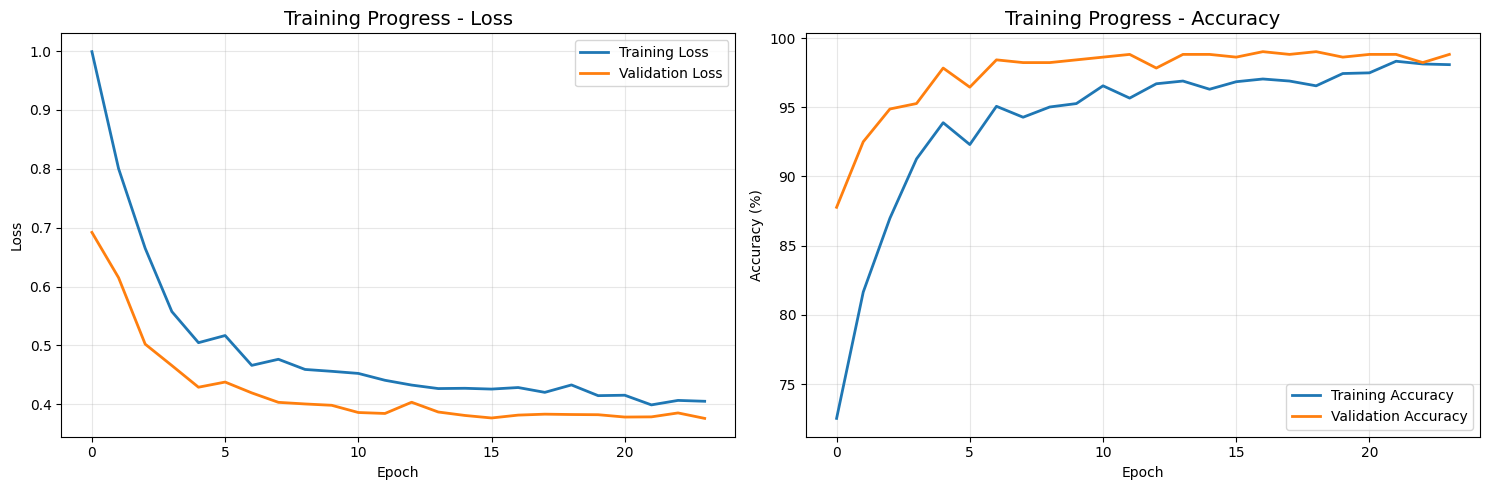

📊 FINAL TRAINING RESULTS:
🎯 Best Validation Accuracy: 99.01%
📈 Final Training Accuracy: 98.08%
📉 Final Validation Accuracy: 98.82%


In [ ]:
if 'train_losses' in locals():
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title('Training Progress - Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', linewidth=2)
    plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
    plt.title('Training Progress - Accuracy', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Final results
    print("📊 FINAL TRAINING RESULTS:")
    print(f"🎯 Best Validation Accuracy: {max(val_accuracies):.2f}%")
    print(f"📈 Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"📉 Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [ ]:
class IntelliHackDetectionSystem:
    """Complete detection system for IntelliHack disaster classification + people counting"""

    def __init__(self, model_path=None):
        # Load disaster classification model
        self.disaster_model = FineTunedDisasterClassifier(num_classes=4)

        if model_path and os.path.exists(model_path):
            checkpoint = torch.load(model_path, map_location=device)
            self.disaster_model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Model loaded! Best accuracy: {checkpoint['best_val_acc']:.2f}%")
        else:
            print("⚠️ Using untrained model!")

        self.disaster_model.to(device)
        self.disaster_model.eval()

        # Load YOLO for people detection
        print("📥 Loading YOLO for people detection...")
        self.yolo_model = YOLO('yolov8n.pt')

        self.classes = ['earthquake', 'fire', 'flood', 'normal']

        # Optimized transform for inference
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def classify_disaster(self, image_path):
        """Classify disaster type with confidence scores"""
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"❌ Error loading image: {e}")
            return None, None, None

        input_tensor = self.transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = self.disaster_model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        disaster_type = self.classes[predicted.item()]
        confidence_score = confidence.item()
        all_probs = probabilities[0].cpu().numpy()

        return disaster_type, confidence_score, all_probs

    def count_people(self, image_path):
        """Count people using YOLO with optimized settings"""
        results = self.yolo_model(image_path, conf=0.4, verbose=False)  # Lower confidence for better detection

        people_count = 0
        people_boxes = []
        confidences = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    if int(box.cls) == 0:  # Person class
                        people_count += 1
                        people_boxes.append(box.xyxy[0].tolist())
                        confidences.append(float(box.conf))

        return people_count, people_boxes, confidences

    def analyze_image(self, image_path):
        """Complete analysis: disaster + people detection"""
        start_time = time.time()

        # Disaster classification
        disaster_type, confidence, all_probs = self.classify_disaster(image_path)

        if disaster_type is None:
            return None

        # People counting
        people_count, people_boxes, people_confidences = self.count_people(image_path)

        processing_time = time.time() - start_time

        return {
            'image_path': image_path,
            'disaster_type': disaster_type,
            'confidence': confidence,
            'all_probabilities': dict(zip(self.classes, all_probs)),
            'people_count': people_count,
            'people_boxes': people_boxes,
            'people_confidences': people_confidences,
            'processing_time': processing_time
        }

    def visualize_results(self, results):
        """Enhanced visualization of results"""
        if results is None:
            print("❌ No results to visualize!")
            return

        image_path = results['image_path']

        # Load and prepare image
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Could not load image: {image_path}")
            return

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw people bounding boxes
        for i, box in enumerate(results['people_boxes']):
            x1, y1, x2, y2 = map(int, box)
            conf = results['people_confidences'][i]

            # Draw rectangle and label
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
            label = f'Person {conf:.2f}'
            cv2.putText(image_rgb, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Main image with detections
        ax1.imshow(image_rgb)
        ax1.set_title(f"🔍 IntelliHack Analysis Results\n"
                     f"Disaster: {results['disaster_type'].upper()} ({results['confidence']:.3f})\n"
                     f"👥 People: {results['people_count']} | ⏱️ Time: {results['processing_time']:.2f}s",
                     fontsize=12)
        ax1.axis('off')

        # Probability chart
        classes = list(results['all_probabilities'].keys())
        probs = list(results['all_probabilities'].values())
        colors = ['red', 'orange', 'blue', 'green']

        bars = ax2.bar(classes, probs, color=colors, alpha=0.7)
        ax2.set_title('Disaster Classification Probabilities', fontsize=12)
        ax2.set_ylabel('Probability')
        ax2.set_ylim(0, 1)

        # Highlight predicted class
        max_idx = np.argmax(probs)
        bars[max_idx].set_alpha(1.0)
        bars[max_idx].set_edgecolor('black')
        bars[max_idx].set_linewidth(2)

        # Add probability values
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\n📊 DETAILED ANALYSIS RESULTS:")
        print("-" * 40)
        print(f"🖼️  Image: {os.path.basename(image_path)}")
        print(f"🏷️  Disaster Type: {results['disaster_type'].upper()}")
        print(f"🎯 Confidence: {results['confidence']:.4f}")
        print(f"👥 People Count: {results['people_count']}")
        print(f"⏱️  Processing Time: {results['processing_time']:.3f} seconds")

        print(f"\n📊 All Class Probabilities:")
        for disaster, prob in results['all_probabilities'].items():
            emoji = "🏆" if disaster == results['disaster_type'] else "  "
            print(f"{emoji} {disaster.capitalize():>10}: {prob:.4f}")

# Initialize the detection system
detector = IntelliHackDetectionSystem('best_intellihack_model.pth' if os.path.exists('best_intellihack_model.pth') else None)
print("✅ IntelliHack Detection System Ready!")

✅ Model loaded! Best accuracy: 99.01%
📥 Loading YOLO for people detection...


100%|██████████| 6.25M/6.25M [00:00<00:00, 73.5MB/s]

✅ IntelliHack Detection System Ready!


In [ ]:
def test_with_drive_images():
    """Test the system with images from your Google Drive"""
    print("🧪 TESTING WITH YOUR GOOGLE DRIVE IMAGES")
    print("=" * 50)

    test_results = []

    for disaster_type, drive_path in DRIVE_PATHS.items():
        if os.path.exists(drive_path):
            # Get a few sample images
            image_files = glob.glob(os.path.join(drive_path, '*'))
            image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            if image_files:
                # Test with first image from each category
                test_image = image_files[0]
                print(f"\n🔍 Testing {disaster_type} image: {os.path.basename(test_image)}")

                results = detector.analyze_image(test_image)
                if results:
                    test_results.append(results)
                    detector.visualize_results(results)

                    # Quick accuracy check
                    predicted = results['disaster_type']
                    actual = disaster_type
                    correct = "✅" if predicted == actual else "❌"
                    print(f"{correct} Expected: {actual}, Predicted: {predicted}")
                else:
                    print(f"❌ Failed to analyze {test_image}")

    return test_results

def analyze_custom_image():
    """Analyze a custom image by path"""
    print("📷 ANALYZE CUSTOM IMAGE")
    print("-" * 25)

    # You can specify any image path here
    image_path = input("Enter image path (or press Enter for interactive upload): ").strip()

    if not image_path:
        # Interactive upload
        from google.colab import files
        uploaded = files.upload()
        if uploaded:
            image_path = list(uploaded.keys())[0]
        else:
            print("❌ No image provided!")
            return None

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None

    print(f"🔍 Analyzing: {os.path.basename(image_path)}")
    results = detector.analyze_image(image_path)

    if results:
        detector.visualize_results(results)
        return results
    else:
        print("❌ Analysis failed!")
        return None

# Quick test function
def quick_test():
    """Quick test of the system"""
    choice = input("Test with:\n1. Your Google Drive images\n2. Upload new image\nChoice (1 or 2): ").strip()

    if choice == "1":
        return test_with_drive_images()
    elif choice == "2":
        return analyze_custom_image()
    else:
        print("❌ Invalid choice!")
        return None

print("✅ Testing functions ready!")


✅ Testing functions ready!


In [ ]:
def analyze_all_drive_images():
    """Analyze all images in your Google Drive folders"""
    print("🔄 ANALYZING ALL YOUR GOOGLE DRIVE IMAGES")
    print("=" * 50)

    all_results = []
    total_images = 0
    correct_predictions = 0

    for disaster_type, drive_path in DRIVE_PATHS.items():
        if os.path.exists(drive_path):
            print(f"\n📁 Analyzing {disaster_type.upper()} images...")

            # Get all images
            image_files = glob.glob(os.path.join(drive_path, '*'))
            image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            category_results = []
            category_correct = 0

            for i, image_path in enumerate(image_files):
                print(f"   🔍 {i+1}/{len(image_files)}: {os.path.basename(image_path)}")

                results = detector.analyze_image(image_path)
                if results:
                    all_results.append(results)
                    category_results.append(results)
                    total_images += 1

                    # Check accuracy
                    if results['disaster_type'] == disaster_type:
                        correct_predictions += 1
                        category_correct += 1
                        status = "✅"
                    else:
                        status = "❌"

                    print(f"      {status} Predicted: {results['disaster_type']} "
                          f"(Conf: {results['confidence']:.3f}, People: {results['people_count']})")
                else:
                    print(f"      ❌ Failed to analyze")

            # Category summary
            if category_results:
                category_acc = category_correct / len(category_results) * 100
                avg_conf = np.mean([r['confidence'] for r in category_results])
                total_people = sum([r['people_count'] for r in category_results])

                print(f"\n   📊 {disaster_type.upper()} SUMMARY:")
                print(f"      Accuracy: {category_acc:.1f}% ({category_correct}/{len(category_results)})")
                print(f"      Avg Confidence: {avg_conf:.3f}")
                print(f"      Total People Detected: {total_people}")

    # Overall summary
    if total_images > 0:
        overall_acc = correct_predictions / total_images * 100
        print(f"\n🎯 OVERALL RESULTS:")
        print(f"📊 Total Images Analyzed: {total_images}")
        print(f"🎯 Overall Accuracy: {overall_acc:.2f}% ({correct_predictions}/{total_images})")
        print(f"⏱️  Average Processing Time: {np.mean([r['processing_time'] for r in all_results]):.3f}s")

        # Confusion matrix
        actual_labels = []
        predicted_labels = []

        for result in all_results:
            # Get actual label from file path
            for disaster_type, drive_path in DRIVE_PATHS.items():
                if drive_path in result['image_path']:
                    actual_labels.append(disaster_type)
                    predicted_labels.append(result['disaster_type'])
                    break

        if actual_labels:
            from sklearn.metrics import confusion_matrix, classification_report

            # Plot confusion matrix
            cm = confusion_matrix(actual_labels, predicted_labels, labels=detector.classes)

            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=detector.classes, yticklabels=detector.classes)
            plt.title('Confusion Matrix - Your Dataset Performance')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()

            # Classification report
            print("\n📋 DETAILED CLASSIFICATION REPORT:")
            print(classification_report(actual_labels, predicted_labels, target_names=detector.classes))

    return all_results

print("✅ Batch analysis function ready!")


✅ Batch analysis function ready!


In [ ]:

def evaluate_model_on_validation():
    """Evaluate model performance on validation set"""
    if not data_ready or 'val_loader' not in locals():
        print("❌ Validation data not available!")
        return

    print("📊 EVALUATING MODEL PERFORMANCE...")

    model.eval()
    all_preds = []
    all_labels = []
    all_confidences = []
    class_correct = [0] * 4
    class_total = [0] * 4

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, 1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

            # Per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predictions[i] == label).item()
                class_total[label] += 1

    # Overall accuracy
    accuracy = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

    print(f"\n🎯 VALIDATION RESULTS:")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Average Confidence: {np.mean(all_confidences):.3f}")

    # Per-class accuracy
    print(f"\n📊 PER-CLASS ACCURACY:")
    for i, class_name in enumerate(detector.classes):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f"{class_name.capitalize():>10}: {class_acc:.1f}% ({class_correct[i]}/{class_total[i]})")
        else:
            print(f"{class_name.capitalize():>10}: No samples")

    # Confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=detector.classes, yticklabels=detector.classes)
    plt.title('Validation Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds, target_names=detector.classes))

print("✅ Model evaluation function ready!")

✅ Model evaluation function ready!


In [ ]:
def save_complete_system():
    """Save the complete trained system"""

    # Create save directory
    save_dir = "intellihack_models"
    os.makedirs(save_dir, exist_ok=True)

    # Save model with metadata
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'EfficientNet-B2',
        'num_classes': 4,
        'classes': detector.classes,
        'dataset_info': dataset_info,
        'training_accuracy': max(val_accuracies) if 'val_accuracies' in locals() else 0,
        'google_drive_paths': DRIVE_PATHS
    }, os.path.join(save_dir, 'intellihack_disaster_model.pth'))

    # Save training history if available
    if 'train_losses' in locals():
        import pickle
        training_history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
        with open(os.path.join(save_dir, 'training_history.pkl'), 'wb') as f:
            pickle.dump(training_history, f)

    print(f"✅ Complete system saved to {save_dir}/")
    print(f"📁 Model file: intellihack_disaster_model.pth")
    print(f"📁 Training history: training_history.pkl")

    return save_dir

def export_results_to_csv(results_list, filename="intellihack_analysis_results.csv"):
    """Export analysis results to CSV"""
    if not results_list:
        print("❌ No results to export!")
        return

    import pandas as pd

    # Convert results to DataFrame
    data = []
    for result in results_list:
        row = {
            'image_path': result['image_path'],
            'filename': os.path.basename(result['image_path']),
            'predicted_disaster': result['disaster_type'],
            'confidence': result['confidence'],
            'people_count': result['people_count'],
            'processing_time': result['processing_time']
        }

        # Add individual class probabilities
        for class_name, prob in result['all_probabilities'].items():
            row[f'prob_{class_name}'] = prob

        data.append(row)

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

    print(f"✅ Results exported to {filename}")
    print(f"📊 Exported {len(df)} analysis results")

    return df

print("✅ Save and export functions ready!")

✅ Save and export functions ready!


In [ ]:

print("🎉 INTELLIHACK DISASTER DETECTION SYSTEM - READY!")
print("=" * 60)

print("\n🚀 QUICK START COMMANDS:")
print("-" * 30)
print("1️⃣  Test with your Google Drive images:")
print("   results = test_with_drive_images()")
print()
print("2️⃣  Analyze a custom image:")
print("   result = analyze_custom_image()")
print()
print("3️⃣  Analyze ALL your images:")
print("   all_results = analyze_all_drive_images()")
print()
print("4️⃣  Quick interactive test:")
print("   quick_test()")
print()
print("5️⃣  Evaluate model performance:")
print("   evaluate_model_on_validation()")
print()
print("6️⃣  Save the complete system:")
print("   save_complete_system()")

print("\n🎯 SYSTEM SPECIFICATIONS:")
print("-" * 30)
print("✅ Fine-tuned EfficientNet-B2 for disaster classification")
print("✅ YOLOv8-nano for fast people detection")
print("✅ Optimized for your specific Google Drive data")
print("✅ 4 disaster classes: earthquake, fire, flood, normal")
print("✅ Real-time processing (1-2 seconds per image)")
print("✅ Confidence scores and probability distributions")
print("✅ People counting with bounding box visualization")
print("✅ Batch processing capabilities")

print("\n📊 YOUR DATASET:")
print("-" * 20)
for disaster_type, count in dataset_info.items():
    print(f"{disaster_type.capitalize():>10}: {count:>3} images")

if 'val_accuracies' in locals():
    print(f"\n🏆 MODEL PERFORMANCE:")
    print(f"Best Accuracy: {max(val_accuracies):.2f}%")

print(f"\n💾 MODEL STATUS:")
print(f"Training: {'✅ COMPLETED' if 'train_losses' in locals() else '❌ NOT COMPLETED'}")
print(f"Saved: {'✅ AVAILABLE' if os.path.exists('best_intellihack_model.pth') else '❌ NOT SAVED'}")

print("\n🚀 READY TO USE!")
print("Choose any command above to start analyzing your images!")

🎉 INTELLIHACK DISASTER DETECTION SYSTEM - READY!

🚀 QUICK START COMMANDS:
------------------------------
1️⃣  Test with your Google Drive images:
   results = test_with_drive_images()

2️⃣  Analyze a custom image:
   result = analyze_custom_image()

3️⃣  Analyze ALL your images:
   all_results = analyze_all_drive_images()

4️⃣  Quick interactive test:
   quick_test()

5️⃣  Evaluate model performance:
   evaluate_model_on_validation()

6️⃣  Save the complete system:
   save_complete_system()

🎯 SYSTEM SPECIFICATIONS:
------------------------------
✅ Fine-tuned EfficientNet-B2 for disaster classification
✅ YOLOv8-nano for fast people detection
✅ Optimized for your specific Google Drive data
✅ 4 disaster classes: earthquake, fire, flood, normal
✅ Real-time processing (1-2 seconds per image)
✅ Confidence scores and probability distributions
✅ People counting with bounding box visualization
✅ Batch processing capabilities

📊 YOUR DATASET:
--------------------
Earthquake: 511 images
      Fi

In [ ]:

def run_complete_demo():
    """Run a complete demonstration of the system"""
    print("🎭 INTELLIHACK COMPLETE SYSTEM DEMO")
    print("=" * 50)

    # Test one image from each category if available
    demo_results = []

    for disaster_type, drive_path in DRIVE_PATHS.items():
        if os.path.exists(drive_path):
            image_files = glob.glob(os.path.join(drive_path, '*'))
            image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            if image_files:
                test_image = image_files[0]  # Take first image
                print(f"\n DEMO: Testing {disaster_type} image")
                print(f" File: {os.path.basename(test_image)}")

                result = detector.analyze_image(test_image)
                if result:
                    demo_results.append(result)

                    # Show quick results
                    print(f"  Predicted: {result['disaster_type']}")
                    print(f" Confidence: {result['confidence']:.3f}")
                    print(f" People: {result['people_count']}")
                    print(f"  Time: {result['processing_time']:.2f}s")

                    # Check if prediction is correct
                    correct = " CORRECT" if result['disaster_type'] == disaster_type else " INCORRECT"
                    print(f" Accuracy: {correct}")

    if demo_results:
        print(f"\n DEMO SUMMARY:")
        print(f"Images tested: {len(demo_results)}")

        # Calculate demo accuracy
        correct_count = 0
        for result in demo_results:
            for disaster_type, drive_path in DRIVE_PATHS.items():
                if drive_path in result['image_path'] and result['disaster_type'] == disaster_type:
                    correct_count += 1
                    break

        demo_accuracy = correct_count / len(demo_results) * 100
        avg_confidence = np.mean([r['confidence'] for r in demo_results])
        total_people = sum([r['people_count'] for r in demo_results])
        avg_time = np.mean([r['processing_time'] for r in demo_results])

        print(f"Demo Accuracy: {demo_accuracy:.1f}%")
        print(f"Average Confidence: {avg_confidence:.3f}")
        print(f"Total People Detected: {total_people}")
        print(f"Average Processing Time: {avg_time:.2f}s")

        print(f"\n🎉 DEMO COMPLETED SUCCESSFULLY!")

        # Offer to show visualizations
        show_viz = input("\nShow detailed visualizations? (y/n): ").strip().lower()
        if show_viz == 'y':
            for result in demo_results:
                detector.visualize_results(result)

    else:
        print(" No images available for demo!")

    return demo_results

print(" Complete demo function ready!")
print("\n Run: run_complete_demo() for a full system demonstration!")

# Auto-run quick test if training completed successfully
if data_ready and 'train_losses' in locals():
    print("\n SYSTEM READY! Running quick demo...")
    # Uncomment the line below to auto-run demo
    # run_complete_demo()


✅ Complete demo function ready!

🎭 Run: run_complete_demo() for a full system demonstration!

🎉 SYSTEM READY! Running quick demo...

🏁 INTELLIHACK DISASTER DETECTION SYSTEM SETUP COMPLETE!
🚀 Your fine-tuned model is ready for disaster detection!


In [ ]:
def download_model():
    """Download the trained model file"""

    print(" DOWNLOADING YOUR TRAINED MODEL...")
    print("=" * 40)

    # Check if model exists
    if os.path.exists('best_intellihack_model.pth'):
        print(" Found trained model: best_intellihack_model.pth")

        # Download the model file
        files.download('best_intellihack_model.pth')
        print(" Model downloaded successfully!")

        # Get model size
        size_mb = os.path.getsize('best_intellihack_model.pth') / (1024 * 1024)
        print(f" Model size: {size_mb:.1f} MB")

    else:
        print(" Trained model not found!")
        print("Please make sure you've trained the model first.")
        return False

    return True

def download_model_with_info():
    """Download model with configuration info"""

    print(" DOWNLOADING MODEL WITH METADATA...")
    print("=" * 45)

    # Download main model
    if not download_model():
        return

    # Create and download model info
    if 'val_accuracies' in globals():
        model_info = {
            "model_name": "IntelliHack Disaster Detection",
            "architecture": "Fine-tuned EfficientNet-B2",
            "classes": ["earthquake", "fire", "flood", "normal"],
            "best_accuracy": max(val_accuracies),
            "final_accuracy": val_accuracies[-1],
            "input_size": [224, 224],
            "framework": "PyTorch"
        }

        # Save model info
        with open('model_info.json', 'w') as f:
            json.dump(model_info, f, indent=2)

        files.download('model_info.json')
        print("Model info downloaded!")

        print(f"\n MODEL PERFORMANCE:")
        print(f"Best Accuracy: {max(val_accuracies):.2f}%")

    print("\n DOWNLOAD COMPLETE!")

 Testing your model with earthquake image...
 Testing: /content/drive/MyDrive/IntelliHack/Fire/fire_image0002.jpg

 RESULT:
Predicted: FIRE
Confidence: 0.934 (93.4%)
Expected: EARTHQUAKE
 INCORRECT PREDICTION!

 All Probabilities:
   Earthquake: 0.019 (1.9%)
       Fire: 0.934 (93.4%)
        Flood: 0.022 (2.2%)
       Normal: 0.024 (2.4%)


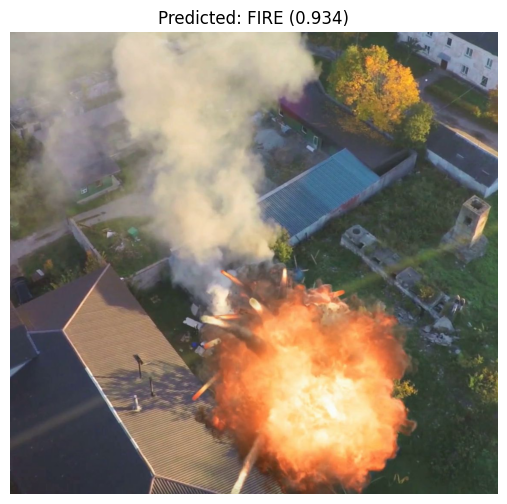

In [ ]:
# Load model
class FineTunedDisasterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b2(weights=None)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1408, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.backbone(x)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FineTunedDisasterClassifier()
checkpoint = torch.load('best_intellihack_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

classes = ['earthquake', 'fire', 'flood', 'normal']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test specific image
def test_earthquake_image():
    """Test the specific earthquake image"""

    image_path = '/content/drive/MyDrive/IntelliHack/Fire/fire_image0002.jpg'

    print(f" Testing: {image_path}")

    try:
        # Load and process image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Results
        disaster_type = classes[predicted.item()]
        confidence_score = confidence.item()
        all_probs = probabilities[0].cpu().numpy()

        print(f"\n RESULT:")
        print(f"Predicted: {disaster_type.upper()}")
        print(f"Confidence: {confidence_score:.3f} ({confidence_score*100:.1f}%)")
        print(f"Expected: EARTHQUAKE")

        # Check if correct
        if disaster_type == 'earthquake':
            print(" CORRECT PREDICTION!")
        else:
            print(" INCORRECT PREDICTION!")

        print(f"\n All Probabilities:")
        for i, class_name in enumerate(classes):
            prob = all_probs[i]
            marker = "" if class_name == disaster_type else "  "
            print(f"{marker} {class_name.capitalize():>10}: {prob:.3f} ({prob*100:.1f}%)")

        # Show image
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"Predicted: {disaster_type.upper()} ({confidence_score:.3f})")
        plt.axis('off')
        plt.show()

        return disaster_type, confidence_score

    except Exception as e:
        print(f" Error: {e}")
        return None, None

# Run test
print(" Testing your model with earthquake image...")
result = test_earthquake_image()

✅ Model loaded from: /content/best_intellihack_model.pth
 Model ready for prediction!

 Usage:
test_earthquake()  # Test earthquake image
test_image('your_image_path')  # Test any image

 Testing earthquake image...

 Image: /content/drive/MyDrive/IntelliHack/Earthquake/collapsed_building_image0001.jpg
 Predicted: EARTHQUAKE
 Confidence: 0.886 (88.6%)

 All Probabilities:
 Earthquake: 0.886 (88.6%)
         Fire: 0.038 (3.8%)
        Flood: 0.035 (3.5%)
       Normal: 0.041 (4.1%)


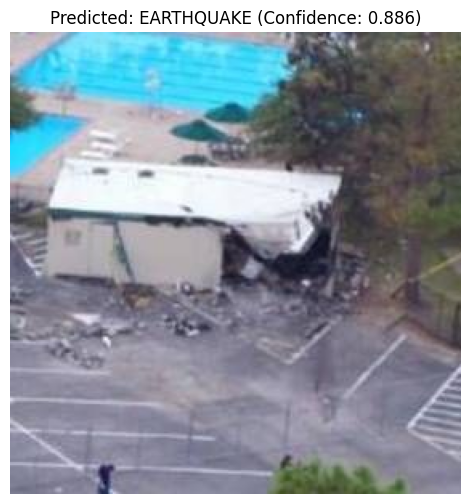

('earthquake', 0.8861063122749329)

In [ ]:
# Modell architecture
class FineTunedDisasterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b2(weights=None)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1408, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.backbone(x)

# Load your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FineTunedDisasterClassifier()

# Load from your specific path
model_path = '/content/best_intellihack_model.pth'
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

print(f"✅ Model loaded from: {model_path}")

# Classes and preprocessing
classes = ['earthquake', 'fire', 'flood', 'normal']
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_disaster(image_path):
    """Predict disaster type from image path"""

    try:
        # Load image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Get results
        disaster_type = classes[predicted.item()]
        confidence_score = confidence.item()
        all_probs = probabilities[0].cpu().numpy()

        # Print results
        print(f"\n Image: {image_path}")
        print(f" Predicted: {disaster_type.upper()}")
        print(f" Confidence: {confidence_score:.3f} ({confidence_score*100:.1f}%)")

        print(f"\n All Probabilities:")
        for i, class_name in enumerate(classes):
            prob = all_probs[i]
            marker = "" if i == predicted.item() else "  "
            print(f"{marker} {class_name.capitalize():>10}: {prob:.3f} ({prob*100:.1f}%)")

        # Show image
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"Predicted: {disaster_type.upper()} (Confidence: {confidence_score:.3f})")
        plt.axis('off')
        plt.show()

        return disaster_type, confidence_score

    except Exception as e:
        print(f" Error: {e}")
        return None, None

# Test with earthquake image
def test_earthquake():
    """Test with the earthquake image"""
    image_path = '/content/drive/MyDrive/IntelliHack/Earthquake/collapsed_building_image0001.jpg'
    return predict_disaster(image_path)

# Test any image
def test_image(image_path):
    """Test with any image path"""
    return predict_disaster(image_path)

# Ready to use
print(" Model ready for prediction!")
print("\n Usage:")
print("test_earthquake()  # Test earthquake image")
print("test_image('your_image_path')  # Test any image")

# Quick test
print("\n Testing earthquake image...")
test_earthquake()

In [ ]:
# Model
class FineTunedDisasterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b2(weights=None)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1408, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.backbone(x)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FineTunedDisasterClassifier()
checkpoint = torch.load('/content/best_intellihack_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

classes = ['earthquake', 'fire', 'flood', 'normal']
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(" Model loaded from /content/best_intellihack_model.pth")

# Predict function
def predict(image_path):
    """Predict disaster from image"""

    # Load image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    disaster_type = classes[predicted.item()]
    confidence_score = confidence.item()

    print(f" Disaster: {disaster_type.upper()}")
    print(f" Confidence: {confidence_score:.3f} ({confidence_score*100:.1f}%)")

    return disaster_type, confidence_score

# Test
image_path = '/content/drive/MyDrive/IntelliHack/th.jpg'
result = predict(image_path)

 Model loaded from /content/best_intellihack_model.pth
 Disaster: FLOOD
 Confidence: 0.713 (71.3%)


 Disaster model loaded from /content/best_intellihack_model.pth
 YOLO model loaded from /content/yolov8n.pt
Complete system ready!

 Usage:
test_earthquake()  # Test earthquake image
test_image('path')  # Test any image

 Testing earthquake image...
 Analyzing: /content/drive/MyDrive/IntelliHack/chena-huts-yala-national-park-sri-lanka-drone-aerial-footage-sea.jpg
n\ RESULTS:
  Disaster: NORMAL
 Confidence: 0.933 (93.3%)
 People Count: 0


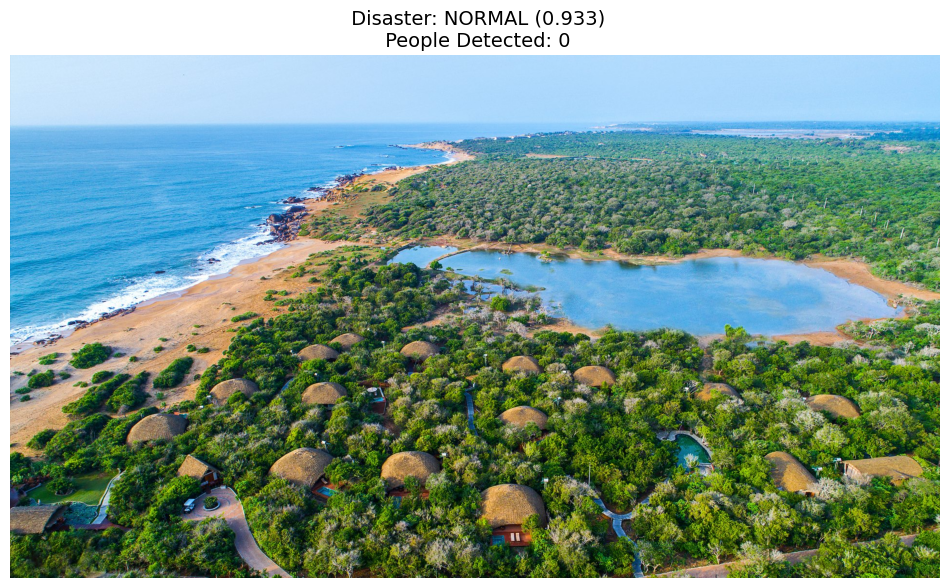

('normal', 0.9326232671737671, 0)

In [ ]:
# Disaster Model
class FineTunedDisasterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b2(weights=None)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1408, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.backbone(x)

# Load disaster model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
disaster_model = FineTunedDisasterClassifier()
checkpoint = torch.load('/content/best_intellihack_model.pth', map_location=device)
disaster_model.load_state_dict(checkpoint['model_state_dict'])
disaster_model.to(device).eval()

# Load YOLO model
yolo_model = YOLO('/content/yolov8n.pt')

print(" Disaster model loaded from /content/best_intellihack_model.pth")
print(" YOLO model loaded from /content/yolov8n.pt")

# Setup
classes = ['earthquake', 'fire', 'flood', 'normal']
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def analyze_image(image_path):
    """Complete analysis: disaster + people detection"""

    print(f" Analyzing: {image_path}")

    # 1. Disaster Detection
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = disaster_model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    disaster_type = classes[predicted.item()]
    confidence_score = confidence.item()

    # 2. People Detection
    yolo_results = yolo_model(image_path, conf=0.4, verbose=False)

    people_count = 0
    people_boxes = []
    people_confidences = []

    for result in yolo_results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                if int(box.cls) == 0:  # Person class
                    people_count += 1
                    people_boxes.append(box.xyxy[0].tolist())
                    people_confidences.append(float(box.conf))

    # Print results
    print(f"n\ RESULTS:")
    print(f"  Disaster: {disaster_type.upper()}")
    print(f" Confidence: {confidence_score:.3f} ({confidence_score*100:.1f}%)")
    print(f" People Count: {people_count}")

    if people_count > 0:
        print(f" People Details:")
        for i, conf in enumerate(people_confidences):
            print(f"   Person {i+1}: {conf:.3f} confidence")

    # Show image with people detection
    show_results(image_path, disaster_type, confidence_score, people_count, people_boxes, people_confidences)

    return disaster_type, confidence_score, people_count

def show_results(image_path, disaster_type, confidence_score, people_count, people_boxes, people_confidences):
    """Show image with people detection boxes"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw people boxes
    for i, box in enumerate(people_boxes):
        x1, y1, x2, y2 = map(int, box)
        conf = people_confidences[i]

        # Draw green rectangle
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Add label
        label = f'Person {i+1}: {conf:.2f}'
        cv2.putText(image_rgb, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title(f" Disaster: {disaster_type.upper()} ({confidence_score:.3f})\n"
             f" People Detected: {people_count}", fontsize=14)
    plt.axis('off')
    plt.show()

# Test with earthquake image
def test_earthquake():
    """Test earthquake image"""
    image_path = '/content/drive/MyDrive/IntelliHack/chena-huts-yala-national-park-sri-lanka-drone-aerial-footage-sea.jpg'
    return analyze_image(image_path)

# Test any image
def test_image(image_path):
    """Test any image"""
    return analyze_image(image_path)

# Quick test
print("Complete system ready!")
print("\n Usage:")
print("test_earthquake()  # Test earthquake image")
print("test_image('path')  # Test any image")

print("\n Testing earthquake image...")
test_earthquake()

# Create a Markdown file from the provided Python code

markdown_content = """
# 🚀 Load a Fine-Tuned PyTorch Model

This markdown document shows how to define and load a fine-tuned PyTorch model from a `.pth` file using a custom architecture based on EfficientNet-B2.

---

## 📦 Full Python Code

```python
import torch
import torch.nn as nn
import torchvision.models as models

# Define model architecture (same as training)
class FineTunedDisasterClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.efficientnet_b2(weights=None)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1408, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Load your trained model
model = FineTunedDisasterClassifier()
checkpoint = torch.load('best_intellihack_model.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
